In [1]:

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_boundary import SVMBoundary

In [8]:
# Initialize the generator with 2D resolution
generator = PerlinNoiseGenerator(res=[60, 60], octv=3, seed=47, time_test=False)

# Generate Perlin noise data
xdataset = generator.perlin_data_xarray()

# generator.plot_2D_xarray()


In [29]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xarray as xr
from numpy.linalg import norm
from scipy.interpolate import interp1d


def boundary_from_contour_with_gradients_2D(xx, yy, Z, boundary_resolution_len: float):
    plt.ioff()  # Turn interactive mode off to suppress showing plots

    # Extract decision boundary points using contour
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black")
    plt.close()

    # Get all paths
    paths = contours.allsegs[0]  # Get all segments for the contour level

    all_interpolated_points = []
    all_gradients = []

    for path_segment in paths:
        vertices = np.array(path_segment)
        distances = norm(vertices[1:] - vertices[:-1], axis=1)
        cumulative_distances = np.cumsum(distances)
        cumulative_distances = np.insert(cumulative_distances, 0, 0)

        # Interpolate points along the path
        path_length = cumulative_distances[-1]
        num_points = int(path_length // boundary_resolution_len) + 1
        evenly_spaced_distances = np.linspace(0, path_length, num=num_points)

        interp_fn = interp1d(cumulative_distances, vertices, axis=0, kind='linear')
        interpolated_points = interp_fn(evenly_spaced_distances)



        if len(interpolated_points) < 2:
            # Add a dummy gradient (e.g., zero) if only one point
            gradients = np.zeros_like(interpolated_points)
        else:
            # Compute gradient vectors (finite difference method)
            gradients = np.zeros_like(interpolated_points)
            for i in range(1, len(interpolated_points) - 1):
                tangent = interpolated_points[i + 1] - interpolated_points[i - 1]
                normal = np.array([-tangent[1], tangent[0]])  # Perpendicular vector
                normal /= norm(normal)  # Normalize the gradient
                gradients[i] = normal * 0.1  # Scale the gradient (optional)

            # Set boundary gradients for the endpoints
            gradients[0] = gradients[1]
            gradients[-1] = gradients[-2]

        # Store points and gradients
        all_interpolated_points.append(interpolated_points)
        all_gradients.append(gradients)



        # Store points and gradients
        all_interpolated_points.append(interpolated_points)
        all_gradients.append(gradients)

    return all_interpolated_points, all_gradients


def plot_2D_boundary(X, y, xx, yy, Z, interp_boundary_points, boundary_gradients):
    # Plot the decision boundary and data points
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, label="Data Points")
    plus_minus = 0.1
    # plt.contour(xx, yy, Z, levels=[-plus_minus,0,plus_minus], linestyles=['-'], colors='k')
    plt.contour(xx, yy, Z, levels=[0,plus_minus], linestyles=['-'], colors='k')

    # Plot interpolated points and gradient vectors
    # for i, interpolated_points in enumerate(interp_boundary_points):
    #     plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], 'go', markersize=5, label=f'Boundary Points (Path {i+1})')



    # Plot boundary points and gradient vectors
    for i, (interpolated_points, gradients) in enumerate(zip(interp_boundary_points, boundary_gradients)):
        plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], 'go', markersize=5)
        plt.quiver(
            interpolated_points[:, 0], interpolated_points[:, 1],
            gradients[:, 0]*.005, gradients[:, 1]*.005,
            angles='xy', scale_units='xy', scale=0.01, color='r', alpha=0.8, headwidth=3
        )

    # Add plot details
    plt.title("SVM Decision Boundary with Gradient Vectors")
    plt.xlim(X[:, 0].min(), X[:, 0].max())
    plt.ylim(X[:, 1].min(), X[:, 1].max())
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.legend()
    plt.show()




def svm_boundary_from_xarray_2D(dataset:xr.Dataset, boundary_resolution_len=0.5, boundary_mesh_resolution = 500):
    """
    Fits an SVM model to the data in the xarray.Dataset and plots the decision boundary.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing 'points' and 'noise_values'.

    Returns:
    - None: Plots the SVM decision boundary and data points.
    """

    # Ensure the required variables are present
    if not {'points', 'noise_values'}.issubset(dataset.variables):
        raise ValueError("Dataset must contain 'points' and 'noise_values' variables.")

    # Extract features and labels
    X = dataset['points'].values  # Shape (num_points, dim)
    y = dataset['noise_values'].values  # Shape (num_points,)


    # Define the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 5, 10, 100],  # Regularization parameter
        'gamma': [0.001, 0.1, 0.5, 1, 5, 10, 50, 100]  # Kernel coefficient
    }


    # Perform grid search to find the best parameters
    svc = SVC(kernel='rbf')
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)

    # Get the best model
    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")




    # Create a grid for decision boundary visualization
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, boundary_mesh_resolution),
                        np.linspace(y_min, y_max, boundary_mesh_resolution))

    # Evaluate the decision function
    Z = best_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # interp_boundary_points = boundary_from_contour(xx, yy, Z, boundary_resolution_len)


    interp_boundary_points, boundary_gradients = boundary_from_contour_with_gradients_2D(xx, yy, Z, boundary_resolution_len)


    # Ensure 2D data for visualization
    if X.shape[1] == 2:
        plot_2D_boundary(X, y, xx, yy, Z, interp_boundary_points, boundary_gradients)


Best parameters: {'C': 10, 'gamma': 100}


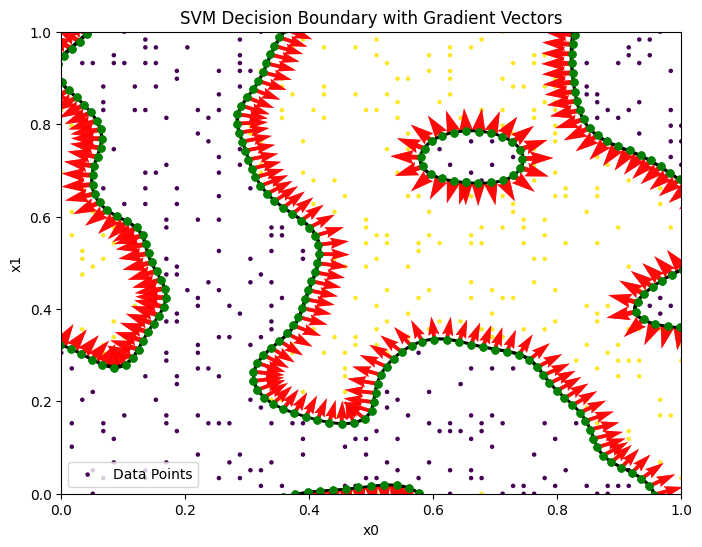

In [30]:
svm_boundary_from_xarray_2D(sample_xarray(xdataset, 500), boundary_resolution_len=0.02)

# 3D case

In [31]:
# Initialize the generator with 2D resolution
generator = PerlinNoiseGenerator(res=[30, 30, 30], octv=3, seed=47, time_test=False)

# Generate Perlin noise data
xdataset = generator.perlin_data_xarray()

# generator.plot_2D_xarray()


In [6]:
SVMBoundary(sample_xarray(xdataset, 1000)).plot_svm_boundary()



ValueError: Requested 1000 samples, but only 900 points are available.

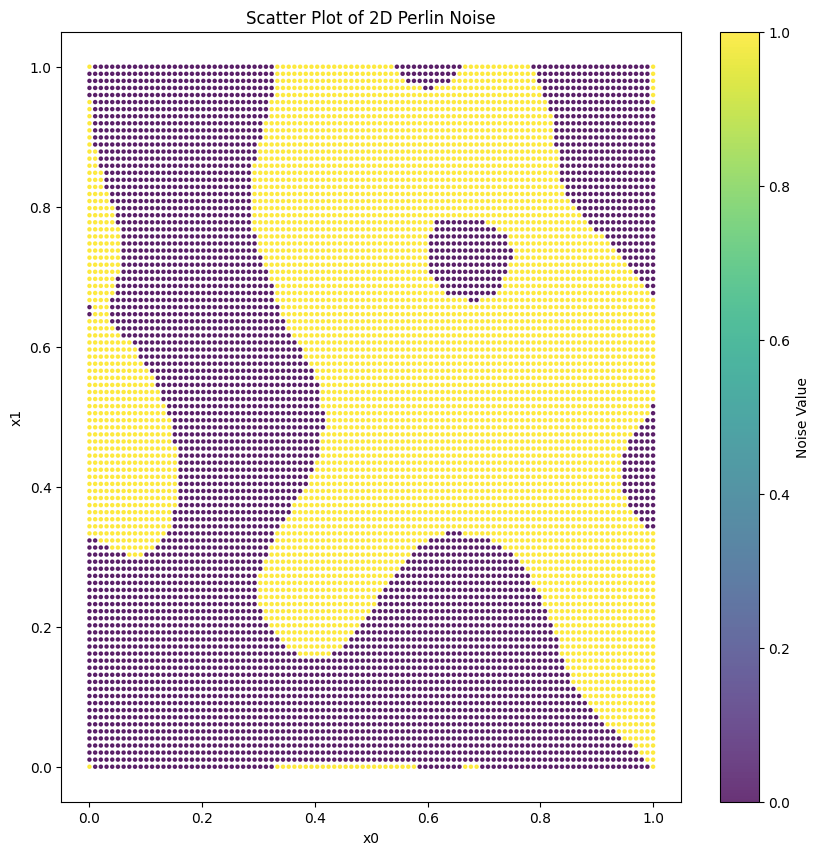

In [7]:

generator.plot_2D_xarray()

grid searching... 
searching best svm
found best one
Best parameters: {'C': 100, 'gamma': 50}
100
Length of boundary points (grid-based): 100
Found 6 boundaries.


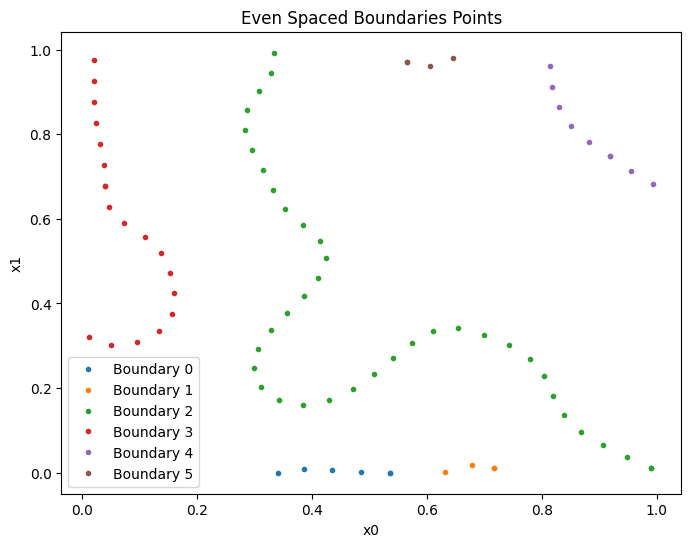

In [8]:
# Plot the identified boundaries
SVMBoundary(sample_xarray(xdataset, 1000)).plot_traversed_boundaries()